# Trials and errors of generating life-time data to test phasor plot

I am trying to make masks with numpy and only then visualize with napari

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import napari

In [2]:
def generate_random_coordinates(image, num_points, seed=7):
    # Generate random x and y coordinates for the points
    coordinates = set()  # Use a set to store unique coordinates
    np.random.seed(seed)
    while len(coordinates) < num_points:
        x = np.random.randint(image[1])
        y = np.random.randint(image[0])
        coordinates.add((x, y))
    
    return list(coordinates)

In [3]:
image_size = (150,150)
num_points = 3

coordinates = generate_random_coordinates(image_size, num_points)
type(coordinates)

list

In [4]:
coordinates

[(25, 67), (103, 92), (142, 23)]

In [5]:
radius1 = np.linalg.norm(np.asarray(coordinates[0])-np.asarray(coordinates[2]))
radius2 = np.linalg.norm(np.asarray(coordinates[1])-np.asarray(coordinates[2]))

In [6]:
def create_circle_mask(image_size, center_coordinate, radius):
    import numpy as np

    mask = np.zeros(image_size, dtype=bool)
    image_grid = np.ogrid[:image_size[1], :image_size[0]]
    distance =  np.linalg.norm(np.asarray(image_grid, dtype=object)-np.asarray(center_coordinate, dtype=object))
    mask[distance <= radius] = True
    return(mask)

In [7]:
mask1 = create_circle_mask(image_size, coordinates[0], radius1)
mask2 = create_circle_mask(image_size, coordinates[1], radius2)

In [8]:
intersection = np.logical_and(mask1,mask2)
circle1 = np.logical_and(mask1,np.logical_not(intersection))
circle2 = np.logical_and(mask2,np.logical_not(intersection))


Text(0.5, 1.0, 'Intersection')

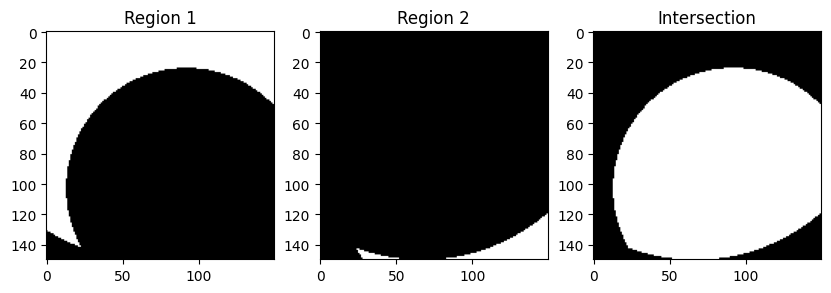

In [9]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.imshow(circle1, cmap='gray')
plt.title('Region 1')

plt.subplot(1, 3, 2)
plt.imshow(circle2, cmap='gray')
plt.title('Region 2')

plt.subplot(1, 3, 3)
plt.imshow(intersection, cmap='gray')
plt.title("Intersection")


In [10]:
laser_frequency = 40 # MHz
number_of_time_points = 30

In [11]:
from napari_flim_phasor_plotter import _synthetic as syn

small_time_array = syn.create_time_array(laser_frequency,number_of_time_points)
#make_synthetic_flim_data(time_array, amplitude, tau)

In [12]:
def calculate_exp(x, A, tau):
    import numpy as np
    if np.isscalar(tau):
        tau = np.array([tau])
        A = np.array([A])
    return np.sum(A[:, None] * np.exp(-1/tau[:, None]*x), axis = 0)

In [13]:
tau_1 = 0.7
tau_2 = 2
amplitude=1
a1 = 0.6
two_amplitudes = np.array([a1, 1-a1])
tau_array = np.array([tau_1,tau_2])
#for monoexp A=1, for biexp A1+A2=1

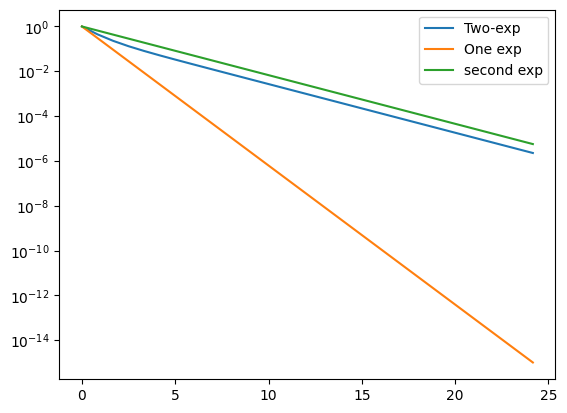

In [14]:
plt.plot(small_time_array, calculate_exp(small_time_array, two_amplitudes, tau_array), label = "Two-exp")
plt.plot(small_time_array, calculate_exp(small_time_array, amplitude, tau_1), label = "One exp")
plt.plot(small_time_array, calculate_exp(small_time_array, amplitude, tau_2), label = "second exp")
plt.yscale('log')
plt.legend()

#i need to generate the image. the intencity is the maximum value in a function while. utime, time, z, x, y

In [15]:
photon_count = 2000
bg_counts = 40

In [17]:
empty_5D_image = bg_counts * np.ones((number_of_time_points, image_size[0], image_size[1]))


circle_array = np.copy(empty_5D_image)
circle_array[:,circle1] = calculate_exp(small_time_array, photon_count*amplitude, tau_1).reshape((30, 1)) * np.ones((30,  circle_array[:,circle1].shape[1]))
circle_array[:,circle2] = calculate_exp(small_time_array, photon_count*amplitude, tau_2).reshape((30, 1)) * np.ones((30, circle_array[:,circle2].shape[1]))
circle_array[:,intersection] =  calculate_exp(small_time_array, photon_count*two_amplitudes, tau_array).reshape((30, 1)) * np.ones((30, circle_array[:,intersection].shape[1]))

In [18]:
filled_5D_image = circle_array[:,np.newaxis, np.newaxis,...]

In [19]:
viewer = napari.Viewer()

In [20]:
viewer.add_image(filled_5D_image)

<Image layer 'filled_5D_image' at 0x7fd47f911070>

/Users/lana/Documents/GitHub/napari-flim-phasor-plotter/src/napari_flim_phasor_plotter/_widget.py:119: FutureWarning: Private attribute access ('Window._dock_widgets') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  value in napari_viewer.window._dock_widgets.items()]
/Users/lana/Documents/GitHub/napari-flim-phasor-plotter/src/napari_flim_phasor_plotter/_widget.py:147: FutureWarning: Private attribute access ('Window._dock_widgets') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  widgets = napari_viewer.window._dock_widgets[


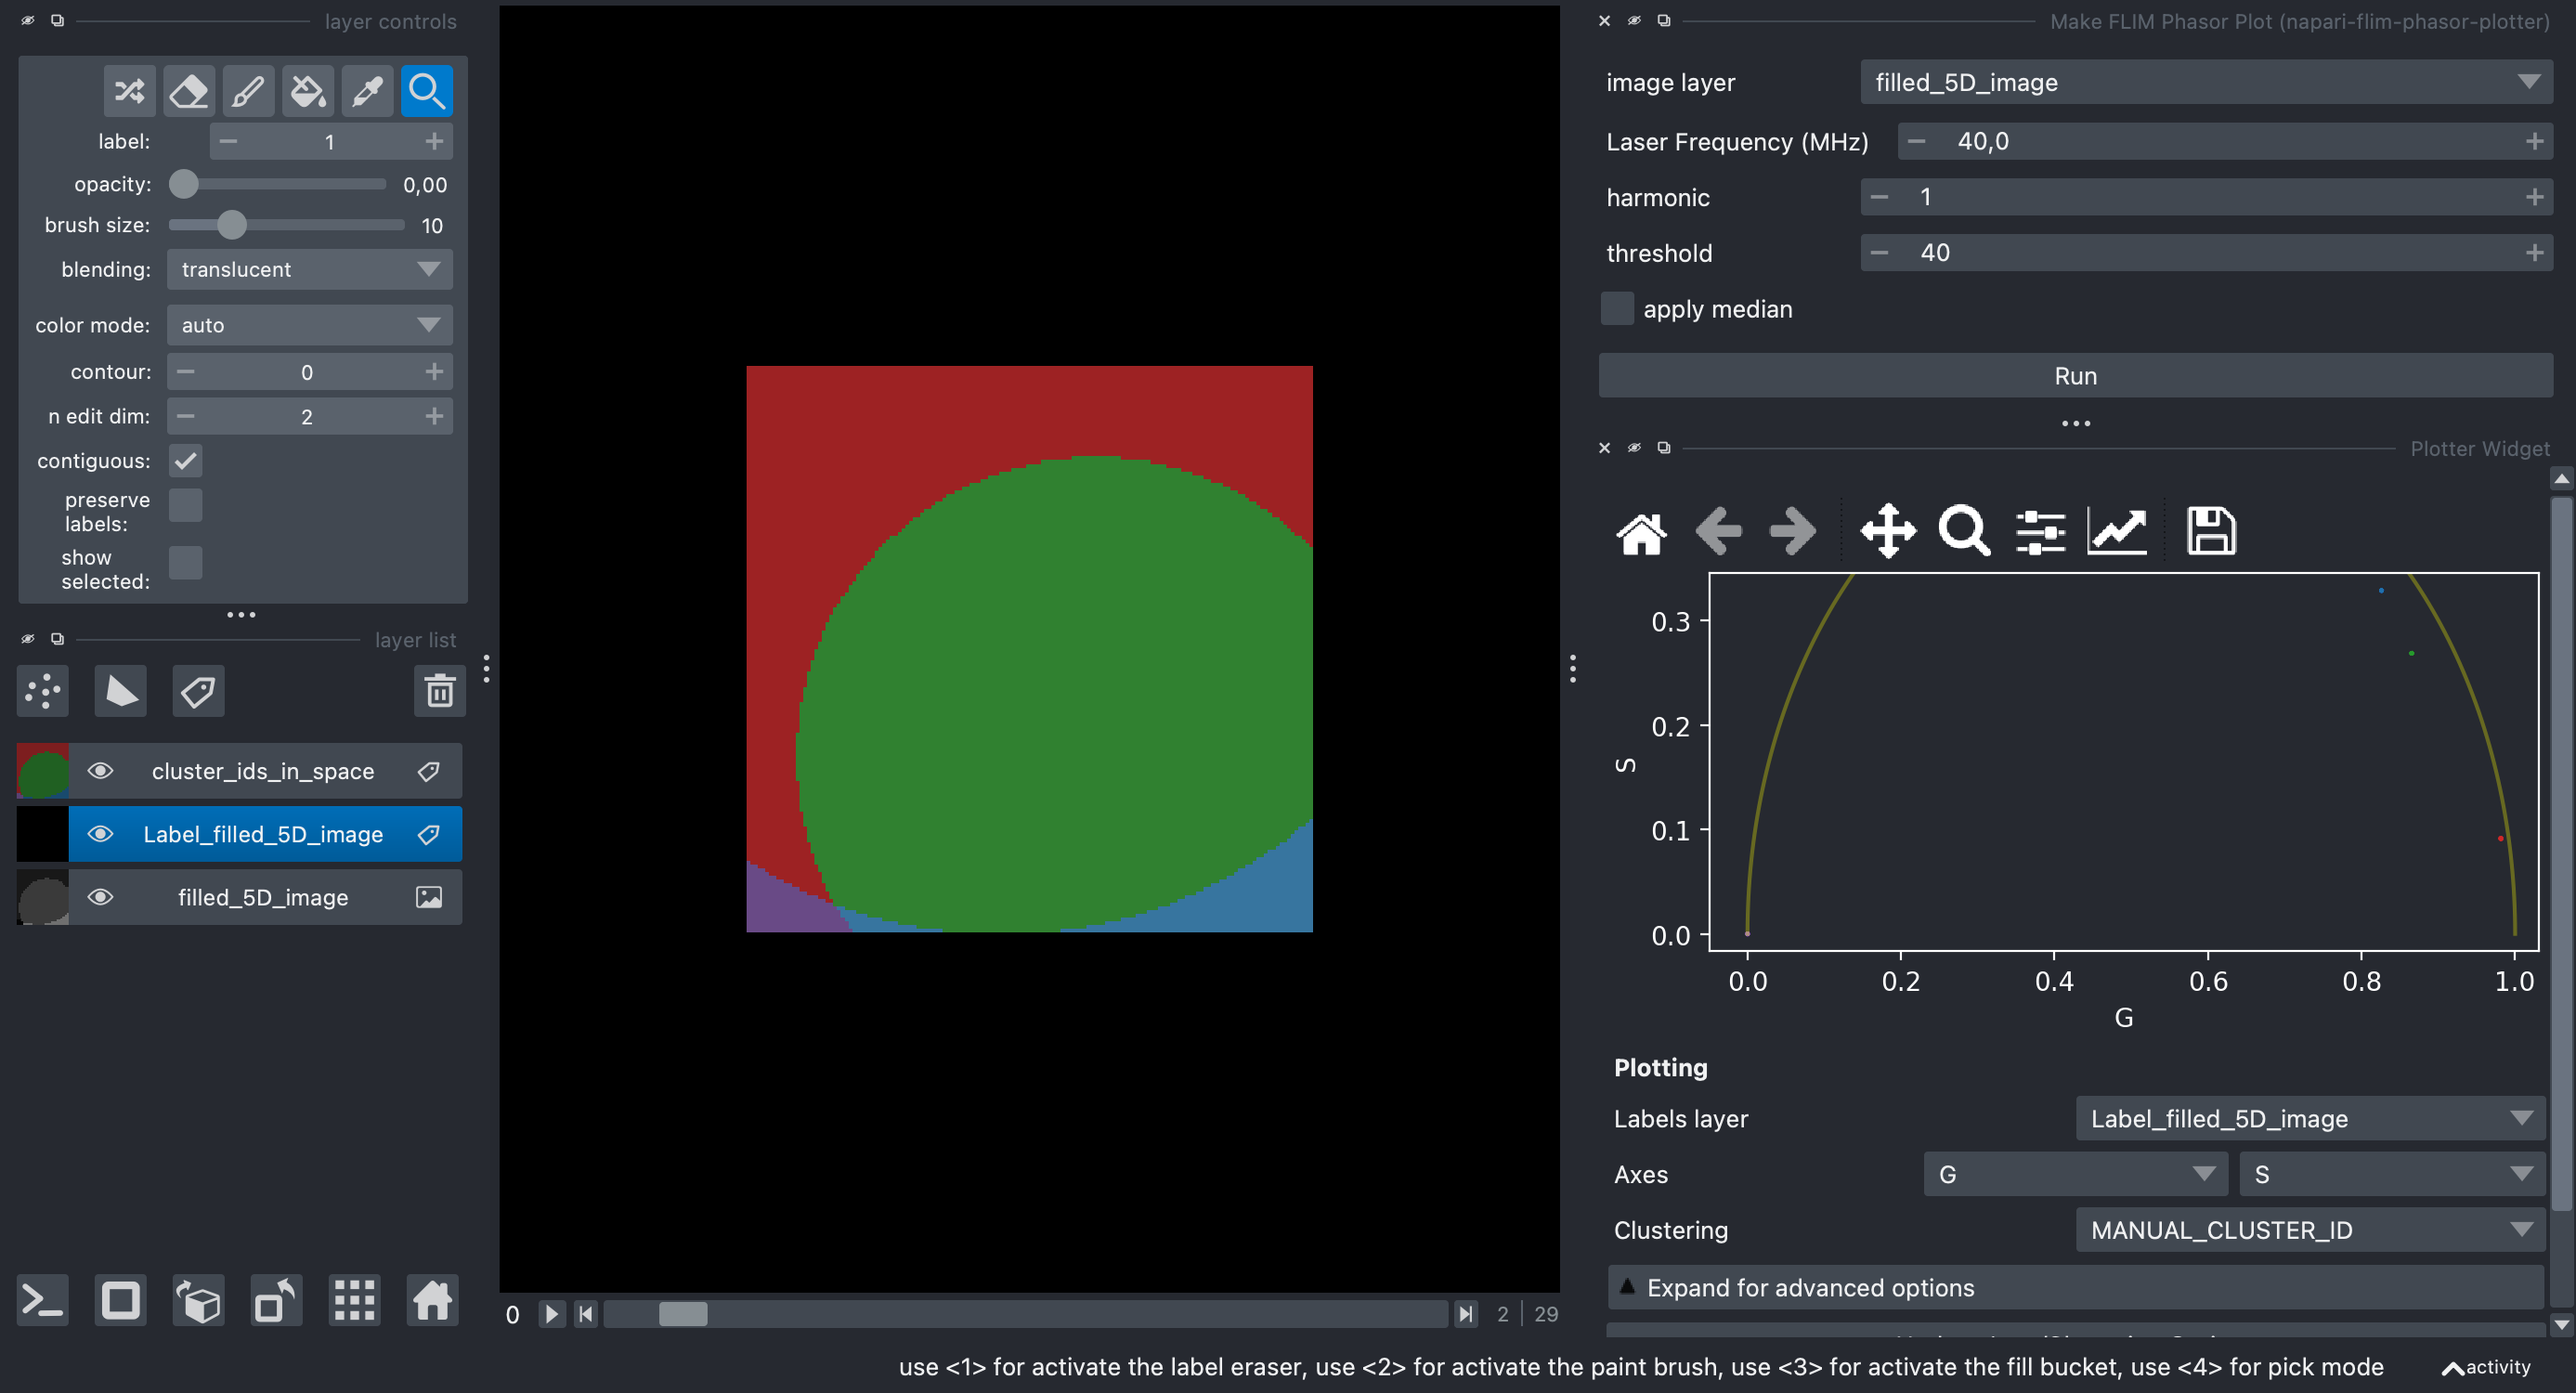

In [21]:
napari.utils.nbscreenshot(viewer)

Shape layer has *data* and *features* parameters:
* data contains the shape coordinates
* features has the names for the shapes, so I could turn these into masks to create a custom image